# 11

## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)



## 1: загружаем
Список переменных:

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


In [80]:
import numpy as np
import pandas as pd
import scipy.stats as ss

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [81]:
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [82]:
df = pd.read_csv('churn.csv')

In [83]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

In [84]:
df.shape

(50000, 12)

In [85]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [86]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [87]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Изменяем тип для дат:


In [88]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [90]:
df.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [91]:
df.describe(include='object')

city   phone
count        50000   49604
unique           3       2
top     Winterfell  iPhone
freq         23336   34582

In [92]:
df.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



last_trip_date          signup_date
count                 50000                50000
unique                  182                   31
top     2014-06-29 00:00:00  2014-01-18 00:00:00
freq                   2036                 2948
first   2014-01-01 00:00:00  2014-01-01 00:00:00
last    2014-07-01 00:00:00  2014-01-31 00:00:00

In [93]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

## 2: графики, гипотезы и тесты

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от вашей компании/данных)

In [94]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [95]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [96]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:

In [97]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [98]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [99]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

### churn
Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

In [100]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [101]:
fig = px.histogram(df, x='churn')
fig.show()

Еще лучше – отразим на графике нормализованные значения (сравниваем не сырые числа):

In [102]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [103]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [104]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [105]:
from scipy.stats import chi2_contingency, chi2 

In [106]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [107]:
stat, p

(2558.394212267425, 0.0)

Интерпретируем результат:

In [56]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

Отклоняем H0


In [111]:
def H0_check(p_value, prob = 0.95, alpha = 1.0 - 0.95):
    if p_value <= alpha:
        return print('Отклоняем H0')
    else:
        return print('Не отклоняем H0')

In [112]:
H0_check(p)

Отклоняем H0


### churn & city
Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [113]:
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

In [114]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', color='city')
fig.show()

In [115]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', color='city', histnorm='probability density')
fig.show()
# в долях

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [116]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [117]:
stat, p

(3821.5510225559633, 0.0)

In [118]:
H0_check(p)

Отклоняем H0


Нулевая гипотеза **ОТКЛОНЯЕТСЯ**, поскольку p-value < 0. 05. Значит, **ВЗАИМОСВЯЗЬ ЕСТЬ**

**Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)**

Проверим распределение на нормальность:

In [119]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [120]:
kings_landing = "King's Landing"

In [121]:
astapor = 'Astapor'

In [122]:
winterfell = 'Winterfell'

In [123]:
shapiro(df.query('city == @kings_landing').trips_in_first_30_days.sample(1000))
# Шапироо слишком чувствителен к большим выборкам, поэто применим .sample(1000)

ShapiroResult(statistic=0.5939117074012756, pvalue=3.208973483303831e-43)

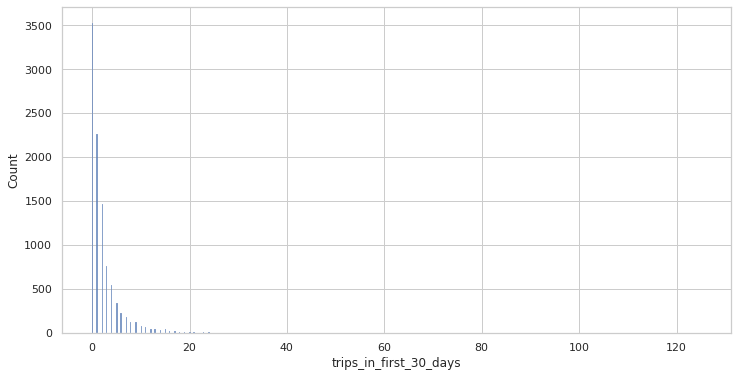

In [124]:
sns.histplot(df.query('city == @kings_landing').trips_in_first_30_days)

In [125]:
shapiro(df.query('city == @astapor').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.44585245847702026, pvalue=0.0)

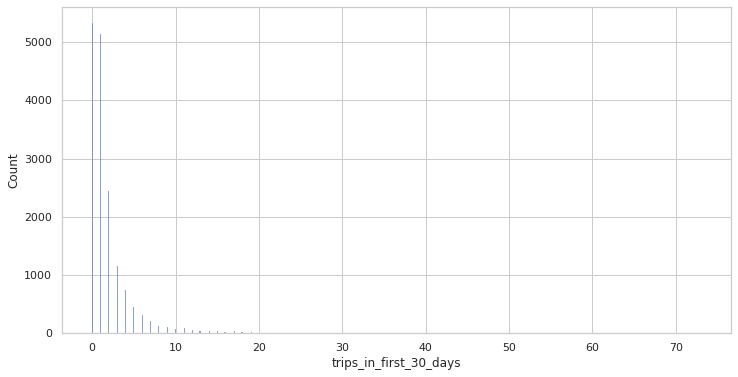

In [126]:
sns.histplot(df.query('city == @astapor').trips_in_first_30_days)
sns.title = 'astapor'

In [127]:
shapiro(df.query('city == @winterfell').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6120690107345581, pvalue=1.5218101322567513e-42)

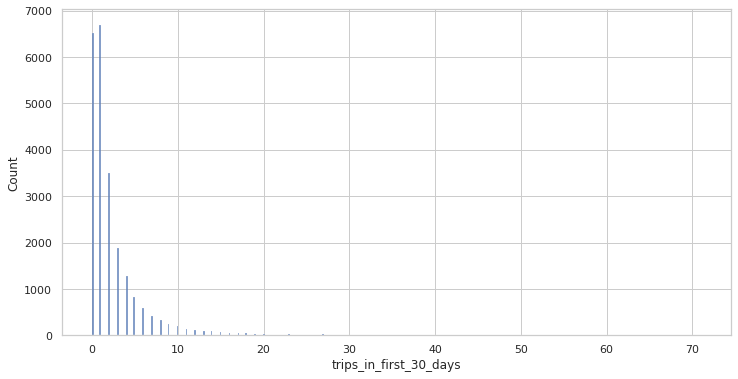

In [128]:
sns.histplot(df.query('city == @winterfell').trips_in_first_30_days)

Распределения **не являются нормальными**, поэтому используем непараметрический аналог ANOVA – **критерий Краскела-Уоллиса**

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [129]:
kings_landing = df.query('city == "King\'s Landing"').trips_in_first_30_days

In [130]:
astapor = df.query('city == "Astapor"').trips_in_first_30_days

In [131]:
winterfell = df.query('city == "Winterfell"').trips_in_first_30_days

In [132]:
stat, p = kruskal(kings_landing, astapor, winterfell)

In [133]:
#Интерпретируем результат:
H0_check(p)

Отклоняем H0


**Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)**

Распределение переменной trips_in_first_30_days **НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ**, поэтому для проверки гипотезы я использую **U-КРИТЕРИЙ МАННА-УИТНИ**

In [134]:
churn = df.query('churn == "churn"').trips_in_first_30_days

In [135]:
not_churn = df.query('churn == "not_churn"').trips_in_first_30_days

In [136]:
stat, p = mannwhitneyu(churn, not_churn)

In [137]:
#Интерпретируем результат:
H0_check(p)

Отклоняем H0


Результат оказался статистически **ЗНАЧИМ**. Значит, **ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ, УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ**